In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import warnings
import pickle
warnings.filterwarnings('ignore')

# Input Data

In [3]:
df = pd.read_csv('Dataset1_Customer_Churn.csv')
df

,CustomerId,Gender,Age,CreditScore,EstimatedSalary,HasCrCard,Exited
0,15634602,Female,42,619,101348.88,1,1
1,15647311,Female,41,608,112542.58,0,0
2,15619304,Female,42,502,113931.57,1,1
3,15701354,Female,39,699,93826.63,0,0
4,15737888,Female,43,850,79084.10,1,0
...,...,...,...,...,...,...,...
9995,15606229,Male,39,771,96270.64,1,0
9996,15569892,Male,35,516,101699.77,1,0
9997,15584532,Female,36,709,42085.58,0,1
9998,15682355,Male,42,772,92888.52,1,1


In [4]:
df.isnull().sum()

CustomerId         0
Gender             0
Age                0
CreditScore        0
EstimatedSalary    0
HasCrCard          0
Exited             0
dtype: int64

In [5]:
df.isna().sum()

CustomerId         0
Gender             0
Age                0
CreditScore        0
EstimatedSalary    0
HasCrCard          0
Exited             0
dtype: int64

In [6]:
df.select_dtypes(np.number).columns

Index(['CustomerId', 'Age', 'CreditScore', 'EstimatedSalary', 'HasCrCard',
       'Exited'],
      dtype='object')

In [7]:
df.select_dtypes('object').columns

Index(['Gender'], dtype='object')

In [8]:
df.nunique()

CustomerId         10000
Gender                 2
Age                   70
CreditScore          460
EstimatedSalary     9999
HasCrCard              2
Exited                 2
dtype: int64

In [9]:
len(df[df.duplicated()])

0

In [10]:
df.describe()

,CustomerId,Age,CreditScore,EstimatedSalary,HasCrCard,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,1.569094e+07,38.921800,650.528800,100090.239881,0.70550,0.203700
std,7.193619e+04,10.487806,96.653299,57510.492818,0.45584,0.402769
min,1.556570e+07,18.000000,350.000000,11.580000,0.00000,0.000000
25%,1.562853e+07,32.000000,584.000000,51002.110000,0.00000,0.000000
50%,1.569074e+07,37.000000,652.000000,100193.915000,1.00000,0.000000
75%,1.575323e+07,44.000000,718.000000,149388.247500,1.00000,0.000000
max,1.581569e+07,92.000000,850.000000,199992.480000,1.00000,1.000000




*  HasCrCard mengandung kategorikal data. Sebanyak 25% dari nasabah tidak memiliki kartu kredit.
*   



In [11]:
df.describe(include='object')

,Gender
count,10000
unique,2
top,Male
freq,5457


Target kita adalah untuk mengidentifikasi seorang nasabah apakah dia akan berhenti menjadi nasabah. Variabel 'Exited' sebagai target yang mengandung tipe data kategorikal, dimana 0 artinya tidak berhenti dan 1 artinya berhenti. Prediktornya adalah variabel 'Age', CreditScore', 'EstimatedSalary', dan 'HasCrCard'. Variabel 'CustomerId' tidak relevan terhadap model sehingga kita abaikan.

In [12]:
df.drop(['CustomerId'], axis=1, inplace=True)

**Label Encoder untuk Gender**

0 = Female ; 1 = Male

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df

,Gender,Age,CreditScore,EstimatedSalary,HasCrCard,Exited
0,0,42,619,101348.88,1,1
1,0,41,608,112542.58,0,0
2,0,42,502,113931.57,1,1
3,0,39,699,93826.63,0,0
4,0,43,850,79084.10,1,0
...,...,...,...,...,...,...
9995,1,39,771,96270.64,1,0
9996,1,35,516,101699.77,1,0
9997,0,36,709,42085.58,0,1
9998,1,42,772,92888.52,1,1


Kategorikal data =

- Gender
- HasCrCard

Numerikal data =
- Age
- CreditScore
- EstimatedSalary

# EDA

## Status Target Data

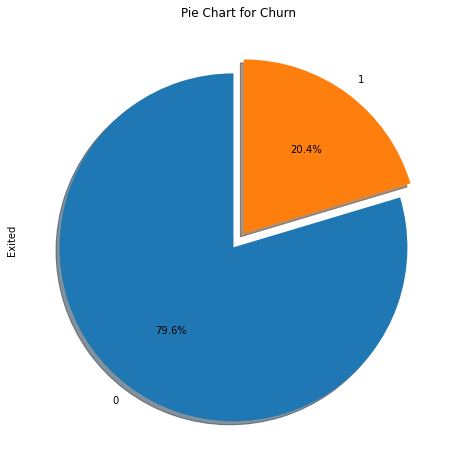

In [14]:
# Let's see how our target data looks like
df['Exited'].value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%', startangle=90, shadow=True, figsize=(10,8))
plt.title('Pie Chart for Churn')
plt.show()

Dapat disimpulkan bahwa sekitar 20% nasabah telah menutup akunnya.

Adanya ketimpangan (skewed) antara total No Exited dan Exited. Proporsi minority class (Exited) sebesar 20.37%, yang dimana masuk ke dalam kategori mild imbalanced data. Maka kita dapat melakukan teknik SMOTE.

In [15]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Sebanyak 2037 Nasabah yang ada di dataset ini yang melakukan Churn, dan 7963 Nasabah tidak melakukan Churn

## Hubungan Kategorikal Data terhadap Target

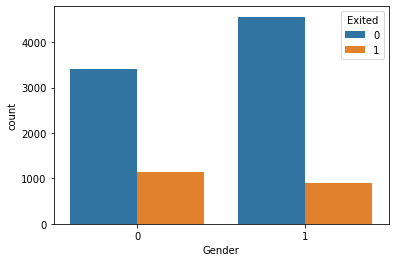

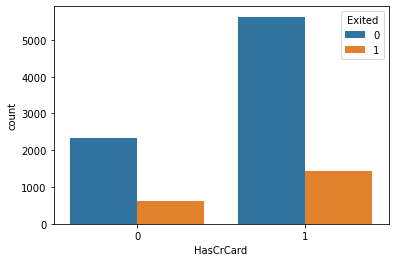

In [16]:
for i, predictor in enumerate(df.drop(columns=['Age', 'CreditScore', 'EstimatedSalary', 'Exited'])):
  plt.figure(i)
  sns.countplot(data=df, x=predictor, hue='Exited')



*   *Hubungan Gender dengan Target Exited*

Lebih dari 1000 Nasabah bergender perempuan yang melakukan Churn, dimana angka tersebut melebihi jumlah Laki-laki yang melakukan Churn yang jumlahnya kurang dari 1000. Hal ini bisa disebabkan karena jumlah nasabah Laki-laki yang tidak melakukan Churn jauh lebih banyak dari nasabah Perempuan, jauh melampaui angka 4000 sedangkan nasabah perempuan di antara 3000 hingga 4000.
*   *Hubungan Jumlah Pengguna Credit Card dengan Target Exited*

Pengguna Credit Card lebih banyak yang melakukan Churn, dimana jumlahnya melampaui angka 1000 dibandingkan yang tidak melakukan Churn. Namun terdapat ketimpangan yang jauh pada pengguna Credit Card yang tidak melakukan Churn sebanyak dari 



## Hubungan Numerikal Data terhadap Target

**1.) Age vs Exited**

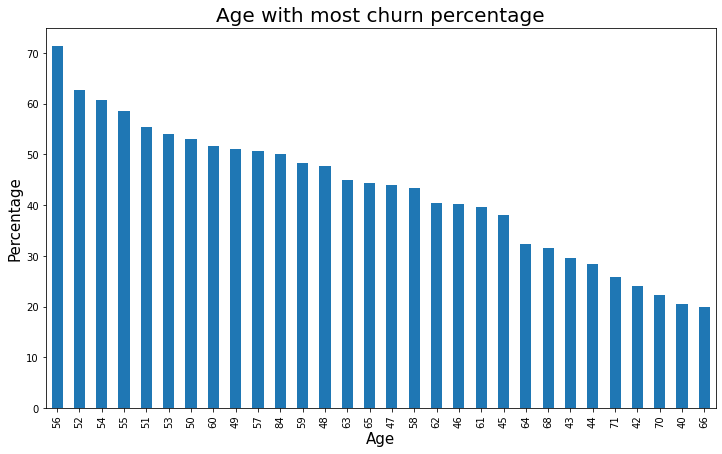

In [17]:
plt.rcParams['figure.figsize'] = (12,7)
color = plt.cm.copper(np.linspace(0, 0.5, 20))
((df.groupby(['Age'])['Exited'].mean())*100).sort_values(ascending=False).head(30).plot.bar()
plt.title('Age with most churn percentage', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.show()

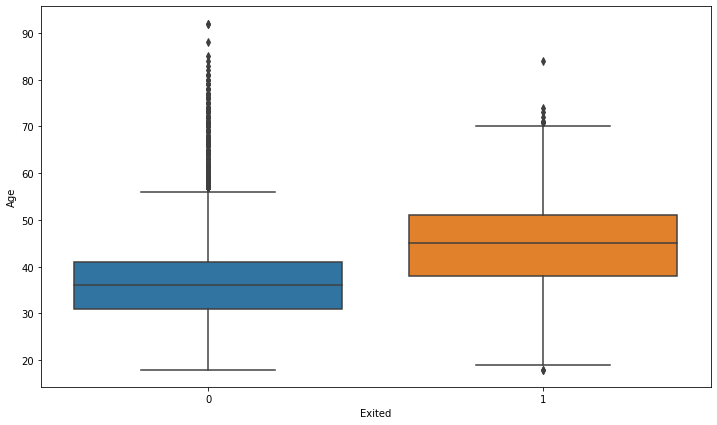

In [18]:
sns.boxplot( x = 'Exited',y = 'Age', data = df )
plt.show()

**2.) CreditScore vs Exited**

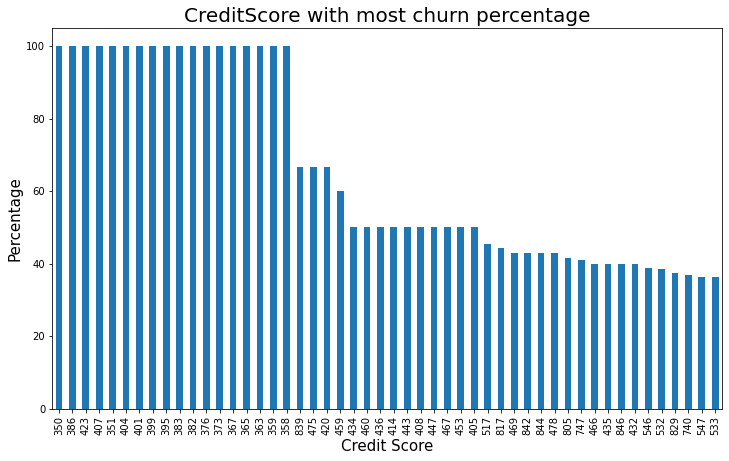

In [19]:
plt.rcParams['figure.figsize'] = (12,7)
# color = plt.cm.copper(np.linspace(0, 0.5, 20))
((df.groupby(['CreditScore'])['Exited'].mean())*100).sort_values(ascending=False).head(50).plot.bar()
plt.title('CreditScore with most churn percentage', fontsize=20)
plt.xlabel('Credit Score', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.show()

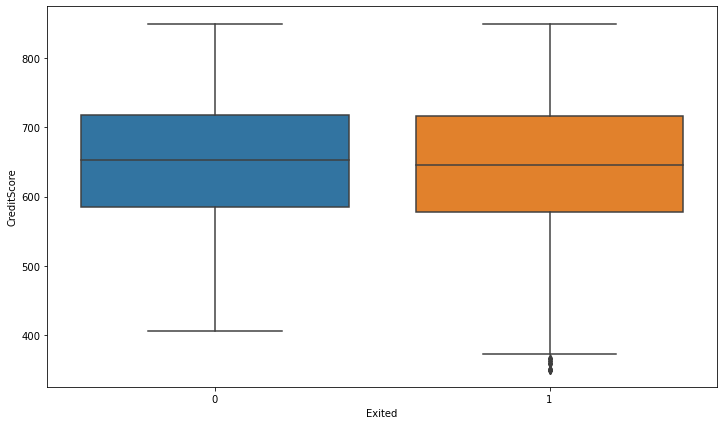

In [20]:
sns.boxplot( x = 'Exited',y = 'CreditScore', data = df )
plt.show()

3.) EstimatedSalary vs Exited

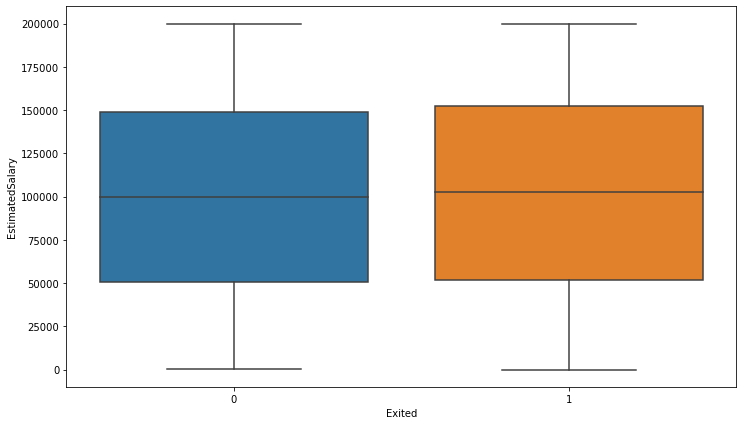

In [21]:
sns.boxplot( x = 'Exited',y = 'EstimatedSalary', data = df )
plt.show()

## Hubungan Korelasi antar Feature

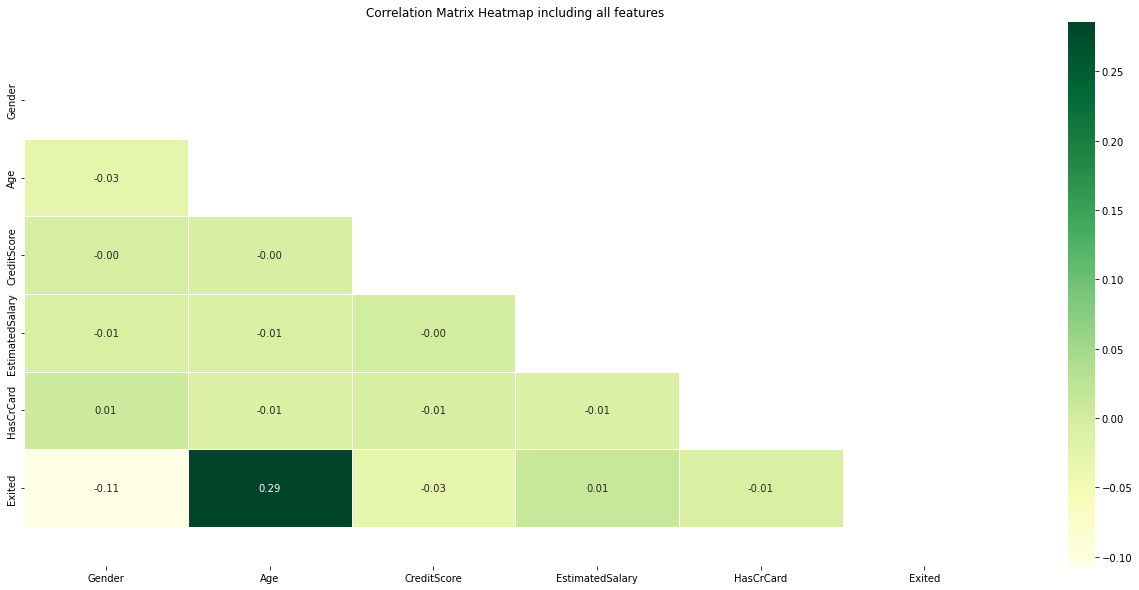

In [22]:
corr_matrix = df.corr()  # Correlation Matrix

# Mask for Heatmap
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(corr_matrix)] = True

# Correlation Matrix Heatmap including all features
fig, ax = plt.subplots(figsize=(22, 10))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGn");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);
ax.set_title("Correlation Matrix Heatmap including all features");

# Feature Engineering

In [23]:
df1 = df.copy()

In [24]:
df1['CrdScoreGivenAge'] = df1['CreditScore'] / df1['Age']

In [25]:
df1

,Gender,Age,CreditScore,EstimatedSalary,HasCrCard,Exited,CrdScoreGivenAge
0,0,42,619,101348.88,1,1,14.738095
1,0,41,608,112542.58,0,0,14.829268
2,0,42,502,113931.57,1,1,11.952381
3,0,39,699,93826.63,0,0,17.923077
4,0,43,850,79084.10,1,0,19.767442
...,...,...,...,...,...,...,...
9995,1,39,771,96270.64,1,0,19.769231
9996,1,35,516,101699.77,1,0,14.742857
9997,0,36,709,42085.58,0,1,19.694444
9998,1,42,772,92888.52,1,1,18.380952


<AxesSubplot:>

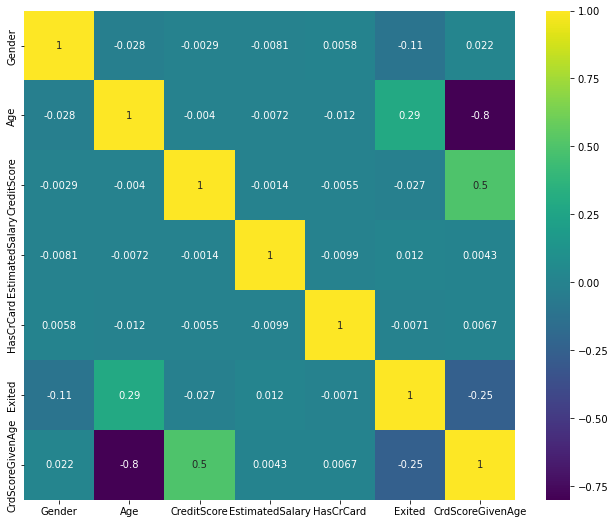

In [26]:
cormat = df1.corr()
plt.figure(figsize=(11,9))
sns.heatmap(cormat, annot=True, cmap='viridis')

# Train-Test Split

In [27]:
X1 = df1.drop('Exited', axis=1)
y1 = df1['Exited']

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.35, random_state=123, stratify=y1)

In [30]:
y1.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

# Feature Scaling

In [31]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [32]:
X1_train = ss.fit_transform(X1_train)
X1_test = ss.fit_transform(X1_test)

In [33]:
X1_train

array([[ 9.09605753e-01, -5.80168368e-01, -1.43598345e+00,
        -9.44650431e-02,  6.55373150e-01, -4.33523045e-01],
       [ 9.09605753e-01,  1.71581233e-03,  3.68717473e-01,
         5.41934186e-02,  6.55373150e-01, -4.03564064e-02],
       [ 9.09605753e-01, -1.74393673e+00, -8.34416478e-01,
         8.34314114e-01,  6.55373150e-01,  1.77010339e+00],
       ...,
       [ 9.09605753e-01,  2.03831044e+00, -2.29684654e+00,
         1.10562438e+00,  6.55373150e-01, -2.01884603e+00],
       [ 9.09605753e-01, -3.86206975e-01,  9.08053382e-01,
        -1.46841664e+00,  6.55373150e-01,  6.22183023e-01],
       [ 9.09605753e-01,  6.80580690e-01,  1.10511843e+00,
        -1.08920967e+00,  6.55373150e-01, -2.55119121e-01]])

# Membangun Model

## KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(1,100)}

In [36]:
knnclassifier = GridSearchCV(knn, parameters, cv=10)

In [37]:
knnclassifier.fit(X1_train, y1_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [38]:
print(knnclassifier.best_score_)
print(knnclassifier.best_params_)

0.8073846153846154
{'n_neighbors': 31}


In [39]:
rel = pd.DataFrame(knnclassifier.cv_results_)
rel.sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
30,0.006983,0.002712,0.036152,0.002244,31,{'n_neighbors': 31},0.812308,0.809231,0.816923,0.809231,0.820000,0.807692,0.801538,0.798462,0.806154,0.792308,0.807385,0.007899,1
19,0.006271,0.000627,0.035571,0.009524,20,{'n_neighbors': 20},0.815385,0.804615,0.826154,0.806154,0.812308,0.807692,0.803077,0.786154,0.804615,0.800000,0.806615,0.009876,2
29,0.006172,0.000593,0.038503,0.005048,30,{'n_neighbors': 30},0.813846,0.804615,0.812308,0.810769,0.823077,0.806154,0.800000,0.793846,0.809231,0.792308,0.806615,0.008919,2
27,0.007875,0.001929,0.039893,0.007582,28,{'n_neighbors': 28},0.810769,0.809231,0.812308,0.810769,0.823077,0.806154,0.795385,0.796923,0.807692,0.792308,0.806462,0.008779,4
23,0.007189,0.001452,0.035863,0.002512,24,{'n_neighbors': 24},0.818462,0.801538,0.815385,0.800000,0.823077,0.809231,0.800000,0.792308,0.806154,0.798462,0.806462,0.009378,4


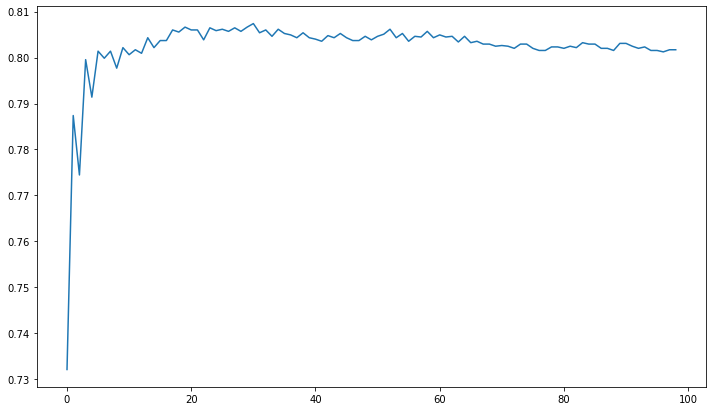

In [40]:
plt.plot(rel['mean_test_score'])

In [41]:
# knnclassifier.fit(X1_test, y1_test)

In [42]:
# print(knnclassifier.best_score_)
# print(knnclassifier.best_params_)

In [43]:
# rel1 = pd.DataFrame(knnclassifier.cv_results_)
# rel1.sort_values(by=['rank_test_score']).head()

In [44]:
# plt.plot(rel1['mean_test_score'])

In [45]:
y1_pred_knn = knnclassifier.predict(X1_test)

In [46]:
y1_pred_knn

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

### KNN Evaluation

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [48]:
print('KNN Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y1_test, y1_pred_knn)))
print('Precision: {:.2f}'.format(precision_score(y1_test, y1_pred_knn)))
print('Recall: {:.2f}'.format(recall_score(y1_test, y1_pred_knn)))
print('f1: {:.2f}'.format(f1_score(y1_test, y1_pred_knn)))

y1_predProba_knn = knnclassifier.predict_proba(X1_test)[::,-1]
print('ROC AUC: {:.2f}'.format(roc_auc_score(y1_test, y1_predProba_knn)))

KNN Score
Accuracy: 0.81
Precision: 0.57
Recall: 0.18
f1: 0.27
ROC AUC: 0.72


## Logistics Regression

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
log1 = LogisticRegression()
log1.fit(X1_train, y1_train)
y1_pred_log = log1.predict(X1_test)

### Logistic Regression Evaluation

In [51]:
print('Logistic Regression Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y1_test, y1_pred_log)))
print('Precision: {:.2f}'.format(precision_score(y1_test, y1_pred_log)))
print('Recall: {:.2f}'.format(recall_score(y1_test, y1_pred_log)))
print('f1: {:.2f}'.format(f1_score(y1_test, y1_pred_log)))

y1_predProba_log = log1.predict_proba(X1_test)[::,-1]
print('ROC AUC: {:.2f}'.format(roc_auc_score(y1_test, y1_predProba_log)))

Logistic Regression Score
Accuracy: 0.79
Precision: 0.34
Recall: 0.05
f1: 0.08
ROC AUC: 0.72


## SVC

In [52]:
from sklearn.svm import SVC

In [53]:
svc1 = SVC(probability=True)
svc1.fit(X1_train, y1_train)
y1_pred_svc = svc1.predict(X1_test)

### SVC Evaluation

In [54]:
print('SVC Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y1_test, y1_pred_svc)))
print('Precision: {:.2f}'.format(precision_score(y1_test, y1_pred_svc)))
print('Recall: {:.2f}'.format(recall_score(y1_test, y1_pred_svc)))
print('f1: {:.2f}'.format(f1_score(y1_test, y1_pred_svc)))

y1_predProba_svc = svc1.predict_proba(X1_test)[::,-1]
print('ROC AUC: {:.2f}'.format(roc_auc_score(y1_test, y1_pred_svc)))

SVC Score
Accuracy: 0.80
Precision: 0.59
Recall: 0.13
f1: 0.22
ROC AUC: 0.55


## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
dectree1 = DecisionTreeClassifier()
dectree1.fit(X1_train, y1_train)
y1_pred_dectree = dectree1.predict(X1_test)

In [57]:
y1_predProba_dectree = dectree1.predict_proba(X1_test)[::,-1]
y1_predProba_dectree

array([1., 0., 0., ..., 0., 0., 0.])

### Decision Tree Evaluation

In [58]:
print('Decision Tree Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y1_test, y1_pred_dectree)))
print('Precision: {:.2f}'.format(precision_score(y1_test, y1_pred_dectree)))
print('Recall: {:.2f}'.format(recall_score(y1_test, y1_pred_dectree)))
print('f1: {:.2f}'.format(f1_score(y1_test, y1_pred_dectree)))

print('ROC AUC: {:.2f}'.format(roc_auc_score(y1_test, y1_predProba_dectree)))

Decision Tree Score
Accuracy: 0.72
Precision: 0.32
Recall: 0.32
f1: 0.32
ROC AUC: 0.57


## Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf1 = RandomForestClassifier()
rf1.fit(X1_train, y1_train)
y1_pred_rf = rf1.predict(X1_test)

In [61]:
y1_predProba_rf = rf1.predict_proba(X1_test)[::,-1]
y1_predProba_rf

array([0.21, 0.02, 0.49, ..., 0.28, 0.36, 0.1 ])

### Random Forest Evaluation

In [62]:
print('Random Forest Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y1_test, y1_pred_rf)))
print('Precision: {:.2f}'.format(precision_score(y1_test, y1_pred_rf)))
print('Recall: {:.2f}'.format(recall_score(y1_test, y1_pred_rf)))
print('f1: {:.2f}'.format(f1_score(y1_test, y1_pred_rf)))

print('ROC AUC: {:.2f}'.format(roc_auc_score(y1_test, y1_predProba_rf)))

Random Forest Score
Accuracy: 0.79
Precision: 0.49
Recall: 0.26
f1: 0.34
ROC AUC: 0.70


# Treating Imbalance Data

In [63]:
X2 = df1.drop('Exited', axis=1)
y2 = df1['Exited']

In [64]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [65]:
from imblearn.over_sampling import SMOTE

In [66]:
X2_smote, y2_smote = SMOTE().fit_resample(X2, y2)

In [67]:
y2_smote.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

**Train-Test Balanced Data Split**

In [68]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_smote, y2_smote, test_size=0.35, random_state=123)

In [69]:
# Feature Scaling
X2_train = ss.fit_transform(X2_train)
X2_test = ss.fit_transform(X2_test)

In [70]:
X2_train

array([[ 1.19789669,  2.0151481 ,  2.15206187, -0.06853917,  0.77401807,
        -0.59825229],
       [ 1.19789669, -0.89786738,  2.19564532,  0.85367124,  0.77401807,
         1.92784145],
       [-0.83479653,  1.21155763, -0.46294523, -0.42079805,  0.77401807,
        -1.08280654],
       ...,
       [ 1.19789669,  0.10662072,  0.70291211, -0.74907642, -1.2919595 ,
        -0.02236996],
       [-0.83479653,  0.00617191, -0.74623766, -1.06405625, -1.2919595 ,
        -0.56223189],
       [ 1.19789669, -0.59652095,  0.40872381, -1.58175655,  0.77401807,
         0.54227221]])

## KNN (Balanced)

In [71]:
knn2 = KNeighborsClassifier()

In [72]:
knnclassifier2 = GridSearchCV(knn2, parameters, cv=10)

In [73]:
knnclassifier2.fit(X2_train, y2_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [74]:
print(knnclassifier2.best_score_)
print(knnclassifier2.best_params_)

0.7418602764254938
{'n_neighbors': 62}


In [75]:
y2_pred_knn = knnclassifier2.predict(X2_test)

In [76]:
y2_predProba_knn = knnclassifier2.predict_proba(X2_test)[::,-1]

In [77]:
y2_predProba_knn

array([0.48387097, 0.69354839, 0.61290323, ..., 0.62903226, 0.29032258,
       0.91935484])

### KNN (Balanced) Evaluation

In [78]:
print('KNN Score (Balanced)')
print('Accuracy: {:.2f}'.format(accuracy_score(y2_test, y2_pred_knn)))
print('Precision: {:.2f}'.format(precision_score(y2_test, y2_pred_knn)))
print('Recall: {:.2f}'.format(recall_score(y2_test, y2_pred_knn)))
print('f1: {:.2f}'.format(f1_score(y2_test, y2_pred_knn)))
print('ROC AUC: {:.2f}'.format(roc_auc_score(y2_test, y2_predProba_knn)))

KNN Score (Balanced)
Accuracy: 0.74
Precision: 0.73
Recall: 0.75
f1: 0.74
ROC AUC: 0.81


## LR (Balanced)

In [79]:
log2 = LogisticRegression()
log2.fit(X2_train, y2_train)
y2_pred_log = log2.predict(X2_test)

### LR (Balanced) Evaluation

In [80]:
print('Logistic Regression (Balanced) Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y2_test, y2_pred_log)))
print('Precision: {:.2f}'.format(precision_score(y2_test, y2_pred_log)))
print('Recall: {:.2f}'.format(recall_score(y2_test, y2_pred_log)))
print('f1: {:.2f}'.format(f1_score(y2_test, y2_pred_log)))

y2_predProba_log = log2.predict_proba(X2_test)[::,-1]
print('ROC AUC: {:.2f}'.format(roc_auc_score(y2_test, y2_predProba_log)))

Logistic Regression (Balanced) Score
Accuracy: 0.72
Precision: 0.70
Recall: 0.74
f1: 0.72
ROC AUC: 0.79


## SVC (Balanced)

In [81]:
svc2 = SVC(probability=True)
svc2.fit(X2_train, y2_train)
y2_pred_svc = svc2.predict(X2_test)

### SVC (Balanced) Evaluation

In [82]:
print('SVC (Balanced) Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y2_test, y2_pred_svc)))
print('Precision: {:.2f}'.format(precision_score(y2_test, y2_pred_svc)))
print('Recall: {:.2f}'.format(recall_score(y2_test, y2_pred_svc)))
print('f1: {:.2f}'.format(f1_score(y2_test, y2_pred_svc)))

y2_predProba_svc = svc2.predict_proba(X2_test)[::,-1]
print('ROC AUC: {:.2f}'.format(roc_auc_score(y2_test, y2_predProba_svc)))

SVC (Balanced) Score
Accuracy: 0.74
Precision: 0.73
Recall: 0.76
f1: 0.74
ROC AUC: 0.81


## Decision Tree (Balanced)

In [83]:
dectree2 = DecisionTreeClassifier()
dectree2.fit(X2_train, y2_train)
y2_pred_dectree = dectree2.predict(X2_test)

In [84]:
y2_predProba_dectree = dectree2.predict_proba(X2_test)[::,-1]
y2_predProba_dectree

array([0., 0., 1., ..., 1., 1., 1.])

### Decision Tree (Balanced) Evaluation

In [85]:
print('Decision Tree (Balanced) Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y2_test, y2_pred_dectree)))
print('Precision: {:.2f}'.format(precision_score(y2_test, y2_pred_dectree)))
print('Recall: {:.2f}'.format(recall_score(y2_test, y2_pred_dectree)))
print('f1: {:.2f}'.format(f1_score(y2_test, y2_pred_dectree)))

print('ROC AUC: {:.2f}'.format(roc_auc_score(y2_test, y2_predProba_dectree)))

Decision Tree (Balanced) Score
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
f1: 0.69
ROC AUC: 0.69


## Random Forest (Balanced)

In [86]:
rf2 = RandomForestClassifier()
rf2.fit(X2_train, y2_train)
y2_pred_rf = rf2.predict(X2_test)

In [87]:
y2_predProba_rf = rf2.predict_proba(X2_test)[::,-1]
y2_predProba_rf

array([0.38, 0.39, 0.79, ..., 0.38, 0.39, 0.97])

### Random Forest (Balanced) Evaluation

In [88]:
print('Random Forest (Balanced) Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y2_test, y2_pred_rf)))
print('Precision: {:.2f}'.format(precision_score(y2_test, y2_pred_rf)))
print('Recall: {:.2f}'.format(recall_score(y2_test, y2_pred_rf)))
print('f1: {:.2f}'.format(f1_score(y2_test, y2_pred_rf)))

print('ROC AUC: {:.2f}'.format(roc_auc_score(y2_test, y2_predProba_rf)))

Random Forest (Balanced) Score
Accuracy: 0.74
Precision: 0.74
Recall: 0.73
f1: 0.74
ROC AUC: 0.82


# Feature Importance

In [89]:
X1_train_fi = X1_train.copy()
X1_test_fi = X1_test.copy()

X2_train_fi = X2_train.copy()
X2_test_fi = X2_test.copy()

**Feature Importance Sebelum SMOTE**

In [90]:
X1_train_fi = pd.DataFrame(X1_train_fi, columns = X1.columns)

X1_test_fi = pd.DataFrame(X1_test_fi, columns=X1.columns)

In [91]:
df_fi=pd.DataFrame(zip(X1_train_fi.columns, rf1.feature_importances_),columns=["Features", "Importance"])
df_fi.sort_values(by="Importance", ascending=False)

,Features,Importance
5,CrdScoreGivenAge,0.265248
3,EstimatedSalary,0.254041
2,CreditScore,0.224261
1,Age,0.216634
4,HasCrCard,0.021662
0,Gender,0.018154


**Feature Importance Setelah SMOTE**

In [92]:
X2_train_fi = pd.DataFrame(X2_train_fi, columns = X2.columns)

X2_test_fi = pd.DataFrame(X2_test_fi, columns=X2.columns)

In [93]:
df_fi=pd.DataFrame(zip(X1_train_fi.columns, rf1.feature_importances_),columns=["Features", "Importance"])
df_fi.sort_values(by="Importance", ascending=False)

,Features,Importance
5,CrdScoreGivenAge,0.265248
3,EstimatedSalary,0.254041
2,CreditScore,0.224261
1,Age,0.216634
4,HasCrCard,0.021662
0,Gender,0.018154


# Junk

In [94]:
# X2_smote = ss.fit_transform(X2_smote)

In [95]:
# rf2.fit(X2_smote, y2_smote)

In [96]:
# import pickle

In [97]:
# filename = 'model.sav'

In [98]:
# pickle.dump(rf2, open(filename, 'wb'))

In [99]:
# load_model = pickle.load(open(filename, 'rb'))

In [100]:
# load_model.predict([[0, 42, 619, 101348.88, 1, 14.738095]])

In [101]:
# import joblib

In [102]:
# joblib.dump(rf2, 'churnpredict')

In [103]:
# mdl = joblib.load('churnpredict')

In [104]:
# mdl.predict([[0, 42, 619, 101348.88, 1, 14.738095]])

In [105]:
# # 0	42	619	101348.88	1	1	14.738095
# input_data = (0, 42, 619, 101348.88, 1, 14.738095)

# # changing the input_data as array
# input_data_asarray = np.asarray(input_data)

# # reshape the array as we are predicting for one instance
# input_data_reshaped = input_data_asarray.reshape(1,-1)

# prediction = rf2.predict(input_data_reshaped)
# print(prediction)

# if (prediction[0] == 0):
#     print('The person is not churned')
# else:
#     print('The person is churned')

# Percobaan tanpa Feature Scaling

# **Optimalization**

In [106]:
Xp = X2_smote.copy()
yp = y2_smote.copy()

In [107]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.35, random_state=1)

In [108]:
knnclassifier2.fit(Xp_train, yp_train)
yp_pred = knnclassifier2.predict(Xp_test)

In [109]:
yp_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [110]:
yp_pred_proba = knnclassifier2.predict_proba(Xp_test)[::,-1]
yp_pred_proba

array([1., 0., 1., ..., 0., 1., 0.])

In [111]:
print('Random Forest (Balanced)(Without Feature Scaling) Score')
print('Accuracy: {:.2f}'.format(accuracy_score(yp_test, yp_pred)))
print('Precision: {:.2f}'.format(precision_score(yp_test, yp_pred)))
print('Recall: {:.2f}'.format(recall_score(yp_test, yp_pred)))
print('f1: {:.2f}'.format(f1_score(yp_test, yp_pred)))

print('ROC AUC: {:.2f}'.format(roc_auc_score(yp_test, yp_pred_proba)))

Random Forest (Balanced)(Without Feature Scaling) Score
Accuracy: 0.71
Precision: 0.70
Recall: 0.76
f1: 0.73
ROC AUC: 0.71


Best Parameter of Random Forest

In [112]:
paramRF = {'n_estimators': np.arange(10,1000), 'max_depth': np.arange(10,100)}

In [113]:
rf_bestParam = GridSearchCV(rf2, paramRF, cv=10)

In [114]:
print(rf_bestParam.get_params())

{'cv': 10, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(), 'n_jobs': None, 'param_grid': {'n_estimators': array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
     

Jadi: Parameter Random Forest jika digunakan GridSearchCV, n_estimator = 100 dan criterion = gini. Max_depth = None, artinya semua daunnya kurang dari min_samples_split. min_samples_split = 2.

In [115]:
rfBest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2)

In [116]:
rfBest.fit(X2_train, y2_train)
y_rf_best_pred = rfBest.predict(X2_test)

In [117]:
y_best_predProba = rfBest.predict_proba(X2_test)[::,-1]
y_best_predProba

array([0.38, 0.48, 0.79, ..., 0.41, 0.46, 0.97])

In [118]:
print('Random Forest (Balanced) Score')
print('Accuracy: {:.2f}'.format(accuracy_score(y2_test, y_rf_best_pred)))
print('Precision: {:.2f}'.format(precision_score(y2_test, y_rf_best_pred)))
print('Recall: {:.2f}'.format(recall_score(y2_test, y_rf_best_pred)))
print('f1: {:.2f}'.format(f1_score(y2_test, y_rf_best_pred)))

print('ROC AUC: {:.2f}'.format(roc_auc_score(y2_test, y_best_predProba)))

Random Forest (Balanced) Score
Accuracy: 0.74
Precision: 0.74
Recall: 0.73
f1: 0.74
ROC AUC: 0.82


# Saving Model

In [119]:
X2_se = X2_smote.copy()
X2_se

y2_se = y2_smote.copy()
X2_se

,Gender,Age,CreditScore,EstimatedSalary,HasCrCard,CrdScoreGivenAge
0,0,42,619,101348.880000,1,14.738095
1,0,41,608,112542.580000,0,14.829268
2,0,42,502,113931.570000,1,11.952381
3,0,39,699,93826.630000,0,17.923077
4,0,43,850,79084.100000,1,19.767442
...,...,...,...,...,...,...
15921,0,57,520,43376.163934,0,9.136012
15922,0,50,696,99369.959251,1,13.936938
15923,0,44,723,191708.135088,0,16.604035
15924,0,35,433,17376.427033,0,12.194572


In [120]:
a_train, a_test, b_train, b_test = train_test_split(X2_se, y2_se, test_size=0.35, random_state=1)

In [121]:
a_train

,Gender,Age,CreditScore,EstimatedSalary,HasCrCard,CrdScoreGivenAge
15242,0,44,487,129994.114169,1,11.125413
4940,0,38,763,31892.820000,0,20.078947
15856,0,46,617,139472.228769,1,13.215096
5679,0,33,778,83556.650000,1,23.575758
11457,1,44,692,187189.972495,0,16.051830
...,...,...,...,...,...,...
905,0,45,672,92027.690000,1,14.933333
5192,0,39,663,101168.900000,1,17.000000
12172,0,41,658,36309.854021,1,16.271837
235,1,42,763,33462.940000,1,18.166667


In [122]:
from sklearn.pipeline import Pipeline

In [123]:
pipe = Pipeline([('scal', StandardScaler()), ('ranfor', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2))])
pipe.fit(a_train, b_train)

Pipeline(steps=[('scal', StandardScaler()),
                ('ranfor', RandomForestClassifier())])

In [124]:
Pipeline(steps=[('scal', StandardScaler()), ('ranfor', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2))])

Pipeline(steps=[('scal', StandardScaler()),
                ('ranfor', RandomForestClassifier())])

In [125]:
pipe.score(a_test, b_test)

0.7463677130044843

In [126]:
# 0	43	850	79084.100000	1	19.767442 -> 0 = No Churn
# 0	39	699	93826.630000	0	17.923077 -> 0 = No Churn
# 0	42	619	101348.880000	1	14.738095 -> 1 = Churn
pipe.predict([[0, 39, 699, 93826.630000, 0, 17.923077]])

array([0], dtype=int64)

In [127]:
import pickle

In [128]:
fileName = 'modelpred.pkl'

In [129]:
pickle.dump(pipe, open(fileName, 'wb'))

In [130]:
loadModel = pickle.load(open('modelpred.pkl', 'rb'))

In [131]:
loadModel.predict([[0, 42, 619, 101348.880000, 1, 14.738095]])

array([1], dtype=int64)

In [132]:
# 0	42	502	113931.570000	1	11.952381 -> 1 = Churn
input_data = (0, 42, 502, 113931.570000, 1, 11.952381)

# changing the input_data as array
input_data_asarray = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_asarray.reshape(1,-1)

prediction = loadModel.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
    print('The person is not churned')
else:
    print('The person is churned')

[1]
The person is churned


**End of Code**